# Conductance-based Spiking Neural Network (conductance-SNN)

## Install required packages

In [1]:
import numpy as np
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy
import math

## Functions used for simulation

### Initialize parameters

Initialize parameters

In [2]:
def initialize_params(N, dt, iterations, beta, gamma, weights='homogeneous'):
    """ Initialize parameters.
        
    Parameters
    ----------
    N : number of neurons
    dt : 
    iterations : 
    beta : 
    weights :
    gamma:
    
    """

    t = np.arange(0, iterations) * dt                    # time
    x_est = np.zeros(iterations)                         # input estimate
    o = np.zeros((N, iterations))                        # spike trains
    voltage = np.zeros((N, iterations))                  # voltages
    D = np.ones((1, N))                                  # ''output kernel''
    if weights == 'homogeneous':
        D = np.ones((1, N)) * gamma
    elif weights == 'heterogeneous':
        D = np.random.normal(1/N, 0.5, size=(1,N))
    T = [(weight ** 2)/2 + beta/2 for weight in D[0]]    # threshold

    return (t, x_est, o, voltage, D, T) 

### Time varying signal

Create time varying signal

In [3]:
def time_varying_signal(c_upp=3):
    """ Initialize time varying input signal. """

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 0

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

### Run simulation

In [31]:
def run(rho, E_e=1, E_i=-1, lambda_constant='C', lambda_val=0):
    """ Run simulation of spike coding network. """
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # compute lambda
        constant = 0
        if lambda_constant == 'C':
            constant = 1/(x[t] + x_est[t] + rho)
        elif lambda_constant == 'P':
            constant =  1/(x[t - 1] + x_est[t - 1] + rho)
        elif lambda_constant == 'V':
            constant = lambda_val
            
        # update voltages
        dVdt =  constant * np.multiply(c[t - 1], E_e - voltage[:, t - 1]) \
                + constant * np.dot(D, o[:, t - 1]) * (E_i - voltage[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]
        
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

### Visualize results

Functions used to visualize results

In [6]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

In [129]:
def visualize(color, plot_voltage=1):
    """ Visualize results of the simulation of the spike coding network. """ 
    
    if plot_voltage == 0:
        plots = 2
    else:
        plots = N + 2
    pl.subplots(plots, 1, figsize=(8, 10))
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate')
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    for i in range(1, N + 1):
        values = zero_to_nan(o[i - 1, :] * i)   
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='N%i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train')
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    counter = 3
    
    if plot_voltage == 1:
        # plot voltage over time
        for i in range(1, N + 1):
            neuron = i + 1
            pl.subplot(plots, 1, counter)
            pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='N%i'%i)
            pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
            pl.plot(np.arange(0, iterations), np.ones(iterations) * E_e, '--r', alpha=0.5, label='Reversal potential E')
            pl.plot(np.arange(0, iterations), np.ones(iterations) * E_i, '--b', alpha=0.5, label='Reversal potential I')
            pl.xlim(0, iterations)
            pl.ylabel('Voltage')
            pl.title('Neuron %i' %i)
            pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            counter = counter + 1

## Functions used to visualize additional data

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = (\frac{x}{\tau} + \dot{x}) (E_{E} - V_{i}) \frac{1}{\lambda} + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i}) \frac{1}{\lambda}$ where $\lambda = (x + \hat{x} + \rho)$

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x} + \rho)}$

In [159]:
def visualize_voltage(rho):
    """ Compute and visualize membrane voltage of each neuron. """
    
    # compute voltage (by method 2)
    voltage2 = np.zeros((N, iterations))
    for t in range(iterations - 1):
        for i in range(N):
            voltage2[i, t] =  np.dot(D[0][i], x[t] - x_est[t]) / np.dot(D[0][i], x[t] + x_est[t] + rho)

    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    # pl.suptitle('Voltage', fontsize=15)
    for i in range(1, N+1):
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = (\frac{x}{\tau} + \dot{x}) (1 - V_{i}) + \sum^{N}_{k = 1} (D_{ik} s_{k}) (-1 - V_{i})$',  fontsize=20)
        counter = counter + 1
        pl.plot(voltage[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylabel('voltage')
        pl.xlabel('time')
        pl.ylim(-2, 2)
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = \frac{D_{i}(x - \hat{x})}{D_{i}(x + \hat{x})}$', fontsize=20)
        counter = counter + 1
        pl.plot(voltage2[i - 1, :], color=color[i - 1][:]/255, label='N%i' %i)
        pl.xlabel('time')
        pl.ylim(-2, 2)
        pl.legend()

## Run simulation

### $\textit{N}$-neurons (homogeneous network)

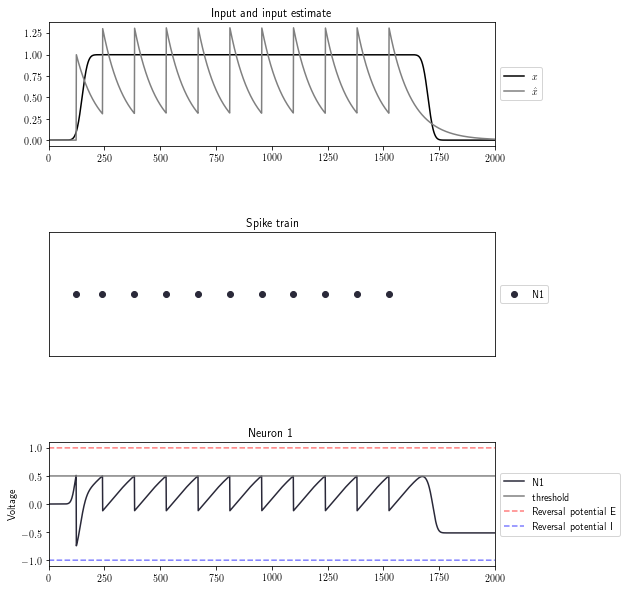

In [160]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
rho = 0.1
lambda_constant = 'C'
lambda_val = 0

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize(color)

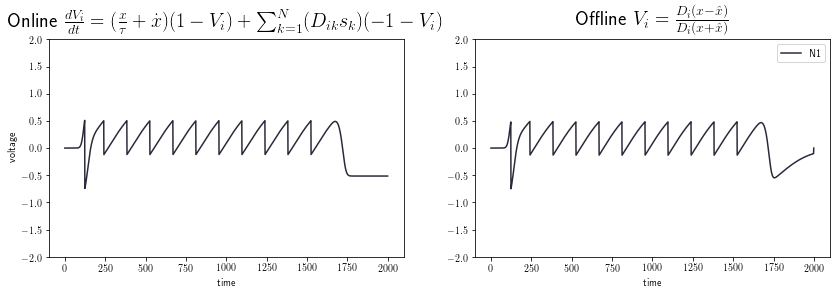

In [161]:
visualize_voltage(rho)

## 1. Online and offline computation of voltage

In [162]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
rho = 0.1

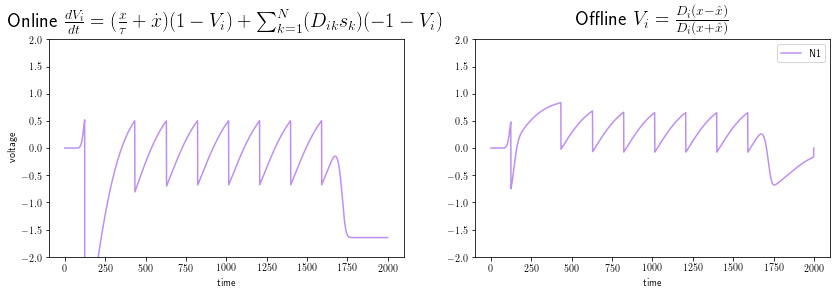

In [163]:
lambda_constant = 'P'

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize_voltage(rho)

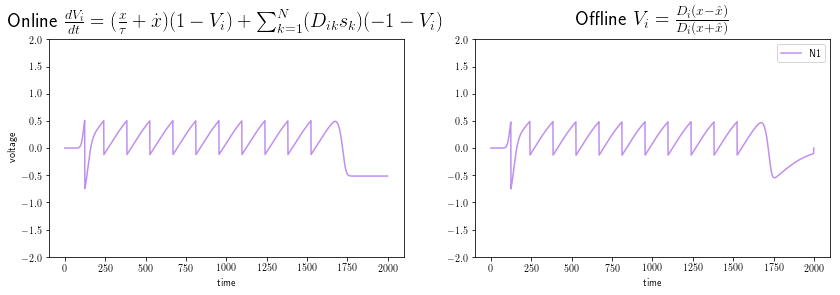

In [164]:
lambda_constant = 'C'

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize_voltage(rho)

## 2. Varying excitatory reversal potential I

### 2.1 Excitatory reversal potential

In [165]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_i = -1
rho = 0.1
lambda_constant = 'C'

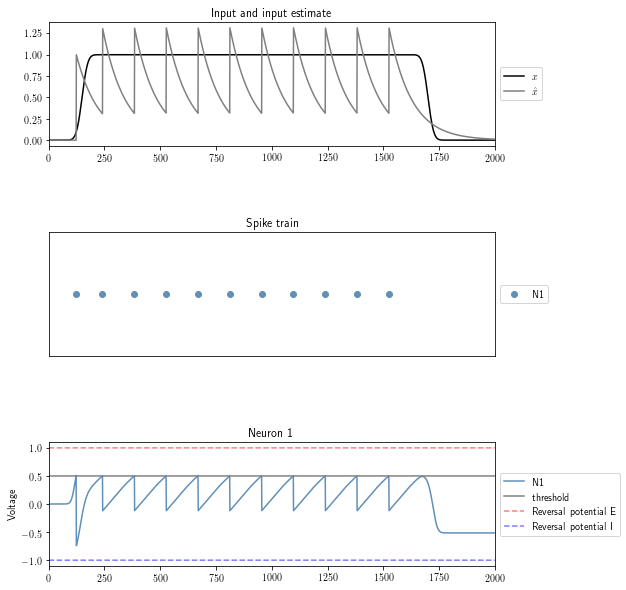

In [166]:
E_e = 1 

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize(color)

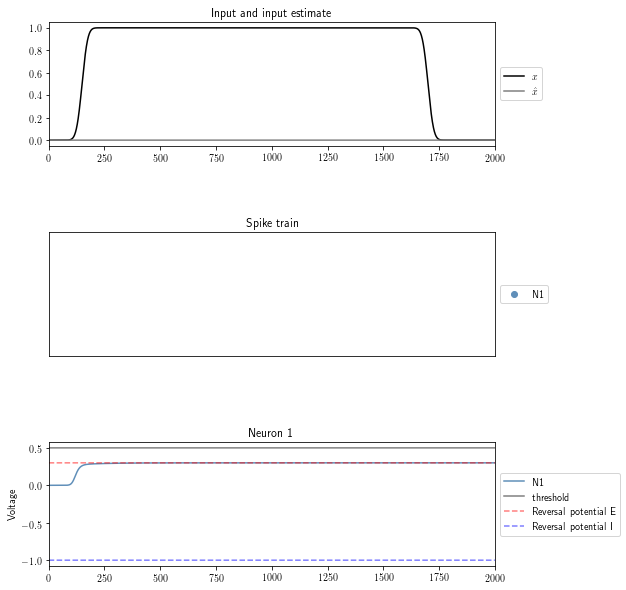

In [167]:
E_e = 0.3 

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize(color)

## 3. Varying excitatory reversal potential II

### 3.1 Excitatory reversal potential

In [138]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_i = -1
rho = 0.1
lambda_constant = 'C'

([<matplotlib.axis.XTick at 0x2d20f782c50>,
 <a list of 2 Text xticklabel objects>)

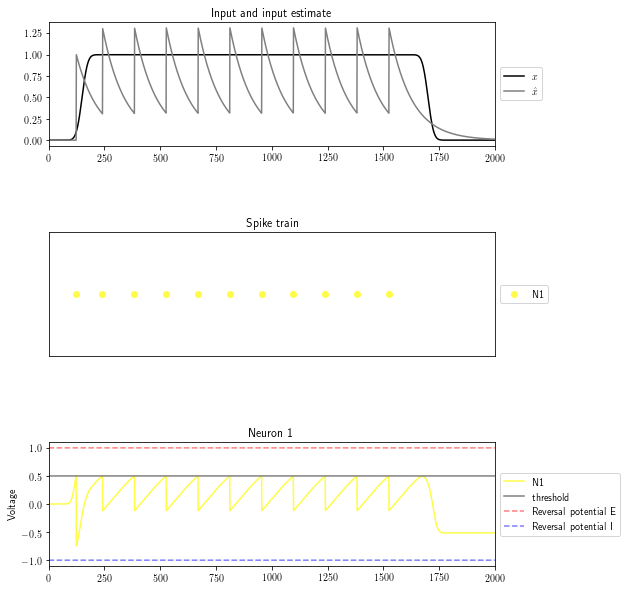

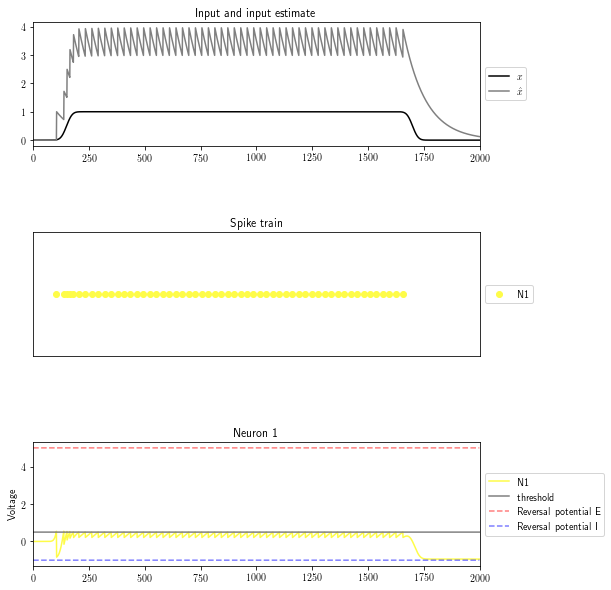

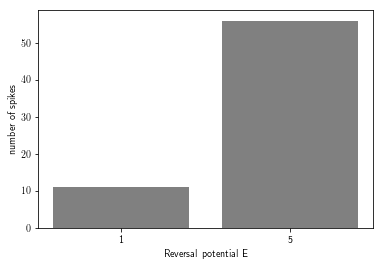

In [139]:
spike_num = []

E_e_values = [1, 5]

# Run II
E_e = E_e_values[0]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
spike_num.append(sum(o[0, :])/100)
visualize(color)

# Run II
E_e = E_e_values[1]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
spike_num.append(sum(o[0, :])/100)
visualize(color)

# plot number of spikes
pl.figure()
pl.ylabel('number of spikes')
bars = ('%i'%E_e_values[0], '%i'%E_e_values[1])
pl.bar(np.arange(len(bars)), spike_num, color='gray')
pl.xlabel('Reversal potential E')
pl.xticks(np.arange(len(bars)), bars)

### 2.1 Inhibitory reversal potential

In [140]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1
rho = 0.1
lambda_constant = 'C'

([<matplotlib.axis.XTick at 0x2d20fc73748>,
 <a list of 2 Text xticklabel objects>)

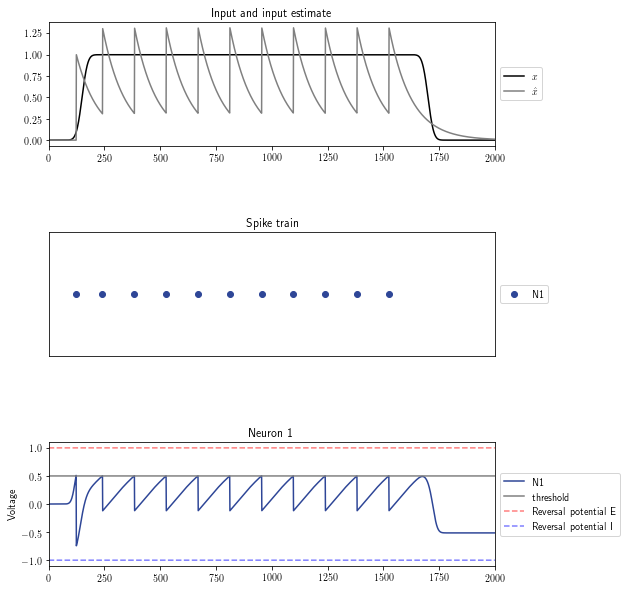

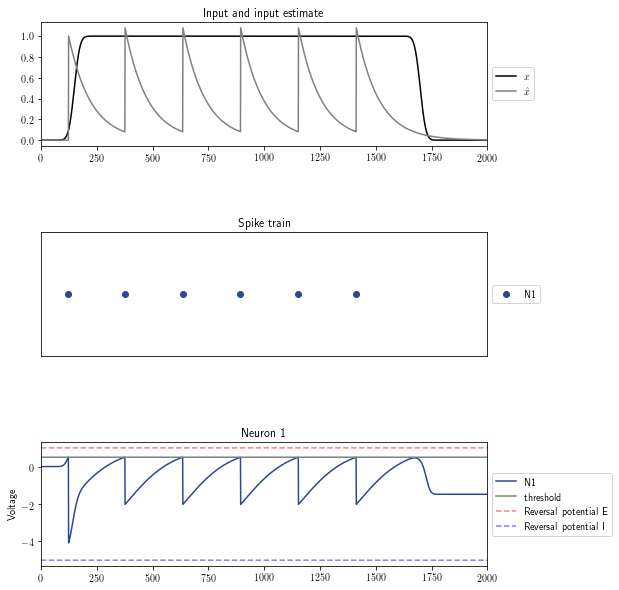

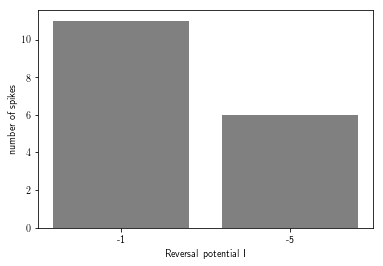

In [141]:
spike_num = []

E_i_values = [-1, -5]

# Run II
E_i = E_i_values[0]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
spike_num.append(sum(o[0, :])/100)
visualize(color)

# Run II
E_i = E_i_values[1]
t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 
run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
spike_num.append(sum(o[0, :])/100)
visualize(color)

# plot number of spikes
pl.figure()
pl.ylabel('number of spikes')
bars = ('%i'%E_i_values[0], '%i'%E_i_values[1])
pl.bar(np.arange(len(bars)), spike_num, color='gray')
pl.xlabel('Reversal potential I')
pl.xticks(np.arange(len(bars)), bars)

## 4. Varying $\lambda$

In [142]:
N = 1
dt = 0.01
iterations = 2000
c_upp = 1
gamma = 1
beta = 0.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
E_e = 1                                                  # excitatory reversal potential
E_i = -1                                                 # inhibitory reversal potential
rho = 0.1

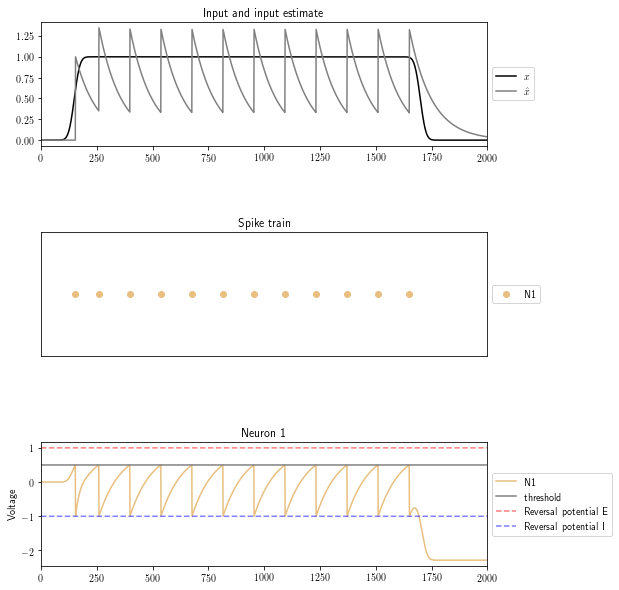

In [143]:
lambda_constant = 'V'
lambda_val = 1

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize(color)

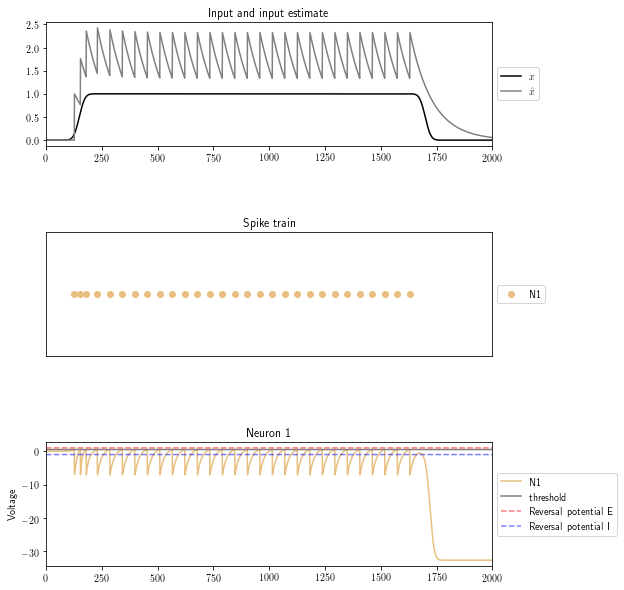

In [144]:
lambda_constant = 'V'
lambda_val = 5

t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
x,c                            = time_varying_signal(c_upp) 

run(rho=rho, E_e=E_e, E_i=E_i, lambda_constant=lambda_constant, lambda_val=lambda_val)
visualize(color)

#### 4. Varying external input

In [617]:
# N = 1
# dt = 0.01
# iterations = 2000
# beta = 0.0                                               # cost
# color = np.random.randint(0, 255, size=(N, 3))           # return set of colors
# E_e = 1.0                                               # excitatory reversal potential
# rho = 0.1
# lambda_constant = True

In [29]:
# gamma = 5
# c_upp = 1

# t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
# x,c                            = time_varying_signal(c_upp) 

# run(rho=rho, E_e=E_e, lambda_constant=lambda_constant)
# #visualize(color)

In [28]:
# gamma = 5
# c_upp = 4

# t, x_est, o, voltage, D, T     = initialize_params(N, dt, iterations, beta, gamma, 'homogeneous')
# x,c                            = time_varying_signal(c_upp) 

# run(rho=rho, E_e=E_e, lambda_constant=lambda_constant)
# #visualize(color)